In [1]:
import yaml
import os
import gym
import numpy as np
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
from abc_env import ABC_env
from naive_agents import DoNothing, FixedPhi
from actor_physicist_agent import RL_phi_agent

import julia
jl = julia.Julia(sysimage="julia_img.so")
from julia import Main

### First make an open ai gym compliant version of the abc environment so we can train out of box RL algos

In [2]:

class ABC_env_gym(gym.Env):
    """
    Environment is 3D ABC environment!! 
    """
    def __init__(self,A,B,C,start_sep, beta, kappa, D, nu,seed=1):
        """ 
        - proper value for D should be derived from sampled lyapunov exponent
        """
        Main.include("abc_numerics.jl")

        super().__init__()
        self.A = A
        self.B = B
        self.C = C
        self.rng = np.random.default_rng(seed=seed)
        self.start_sep = start_sep
        self.sep_vec = self.rng.random(3) - 0.5
        self.sep_vec = self.sep_vec*start_sep/np.linalg.norm(self.sep_vec)
        self.passive = (self.rng.random(3) - 0.5) * 2 * np.pi
        self.active = self.active = self.passive + self.sep_vec
        self.reward=0
        self.deltaT=0.1 # environment step size
        self.time_step=0
        self.limit=10.
        self.kappa = kappa
        self.D = D
        self.nu = nu
        self.beta = beta
        
        
        self.action_space = spaces.Box(low=np.array([-5.]), high=np.array([5.]),dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-100,-100,-100]),
                                            high=np.array([100,100,100],
                                            dtype=np.float32))

    # need to track active and passive not just separation vector

    def reset(self):
        self.sep_vec = self.rng.random(3) - 0.5
        self.sep_vec = self.sep_vec*self.start_sep/np.linalg.norm(self.sep_vec)
        self.passive = (self.rng.random(3) - 0.5) * 2 * np.pi
        self.active = self.active = self.passive + self.sep_vec
        self.reward=0
        self.time_step=0
        return np.array(self.getState(),dtype=np.float32)

    def step(self,action):
        # actions are just a selection of phi for thissteps = env.limit/env.deltaT * num_eps # amount of training steps allowed
        phi = action
        state_string = np.array2string(np.append(self.passive,self.active), separator=",")
        self.passive,self.active, penalty = Main.eval(f"envStep({self.A},{self.B},{self.C},{float(phi)}, {self.nu}, {self.kappa}, {self.beta}, {state_string},{self.deltaT})") 
        self.sep_vec = self.passive - self.active
        self.time_step += 1
        reward = -penalty
        return np.array(self.getState(),dtype=np.float32), reward, self.isOver(), {}


    def eval_step(self,phi):
        """
        Returns the baseline aproximate for the given phi value and the current state

        NOTE: In training you should always evaluate for a fixed phi not the phi the agent picks. 

        """

        dims = 3
        d_tilde = (dims+2) * (dims-1) * self.D
        #useful intermediate value used in the baseline mutiple times
        block = self.nu + 2*phi - d_tilde
        time_remaining = self.limit - self.getTime()
        a = ((self.beta + phi**2)*(1-np.exp(-time_remaining*block)))/block
        b_term1 = dims * self.kappa * (self.beta + phi**2) / (self.nu*(2*phi-d_tilde))
        b_term2 = 1 - np.exp(-self.nu*time_remaining) - self.nu * (1-np.exp(-time_remaining*block))/block
        b = b_term1 * b_term2
        return -(a*self.dist()**2 + b)




    def getState(self):
        steps = env.limit/env.deltaT * num_eps # amount of training steps allowed
        return self.sep_vec
    
    def isOver(self):
        return self.time_step * self.deltaT >= self.limit
        
    def dist(self):
        return np.linalg.norm(self.sep_vec)

    def getTime(self):
        return self.time_step * self.deltaT


In [3]:
# Load parameters for a given config file
config_file = "default_config_abc"

with open(f"config_files/{config_file}.yaml") as cf_file:
        config = yaml.safe_load( cf_file.read() )

# load params from file
dims=3 #abc flows is 3d
A = config["A"]
B = config["B"]
C = config["C"]
start_sep = config["start_sep"]
BETA = config["BETA"]
kappa = config["kappa"] 
D = config["D"]
NU = config["NU"] 
delta_t = config["delta_t"]
t_end = config["t_end"]
num_eps = config["num_eps"]

# intialize and test environment
env = ABC_env_gym(A,B,C,start_sep,BETA,kappa,D,NU)
env.limit = t_end
env.deltaT = delta_t
# It will check your custom environment and output additional warnings if needed
check_env(env)

/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:361: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [6]:
# train out of box A2C if saved model doesn't exists already

steps = env.limit/env.deltaT * num_eps # amount of training steps allowed
model_file="saved_models/stablebase_A2C.zip"
model_A2C = A2C("MlpPolicy", env, verbose=1)
if not os.path.isfile(model_file):
    model_A2C.learn(total_timesteps=steps)
    model_A2C.save("saved_models/stablebase_A2C")
else:
    model_A2C.load("saved_models/stablebase_A2C")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
# train out of box PPO (a more sophisticated actor-critic algo)

steps = env.limit/env.deltaT * num_eps # amount of training steps allowed
model_file="saved_models/stablebase_PPO.zip"
model_PPO = PPO("MlpPolicy", env, verbose=1)
if not os.path.isfile(model_file):
    model_PPO.learn(total_timesteps=steps)
    model_PPO.save("saved_models/stablebase_PPO")
else:
    model_PPO.load("saved_models/stablebase_PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Now compare different agents

In [14]:
# intialize agents and names
actor_physicist = RL_phi_agent(dims,action_scale=5.)
actor_physicist.load_policy(f"saved_models/default_config_abc.pt")

standard_models = [(model_A2C,"A2C"),(model_PPO,"PPO")]
other_models = [(FixedPhi(1.6),"fixed $\phi$"),(actor_physicist,"actor physicist")]




In [15]:
compare_eps = 500
state = env.reset()
results = {}

# stablebase out of box agents
for stable_model,name in standard_models:
    cum_rew=np.zeros(int(env.limit/env.deltaT)+1)
    for ep in range(compare_eps):
        step=0
        episode_rew=0
        while not env.isOver():
            action,_ = stable_model.predict(state)
            state, reward, _, _ = env.step(action)
            episode_rew += reward
            step+=1
            cum_rew[step] = episode_rew
        state = env.reset()
    results[name]=cum_rew

# other agents
for model,name in other_models:
    cum_rew=np.zeros(int(env.limit/env.deltaT)+1)
    for ep in range(compare_eps):
        step=0
        episode_rew=0
        while not env.isOver():
            action = model.sample_action(state)
            state, reward, _, _ = env.step(action)
            episode_rew += reward
            step+=1
            cum_rew[step] = episode_rew
        state = env.reset()
        results[name]=cum_rew

(-1.0, 0.0)

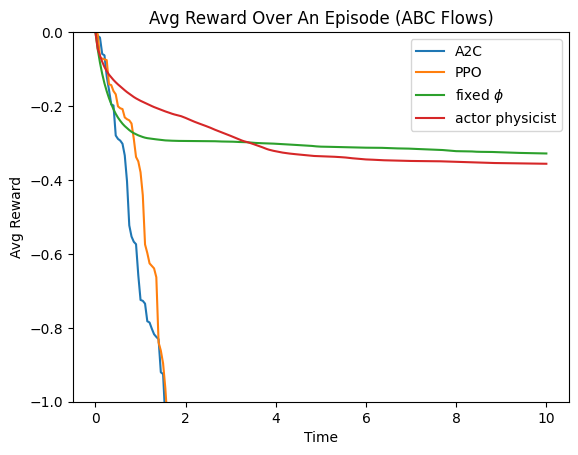

In [16]:
# plot the results averaged over an episode
labels=[]
for name,rews in results.items():
    labels.append(name)
    plt.plot(np.arange(len(rews))/int(1/env.deltaT),rews)
plt.legend(labels=labels)
plt.title("Avg Reward Over An Episode (ABC Flows)")
plt.xlabel("Time")
plt.ylabel("Avg Reward")
plt.ylim(-1,0.)